# 해외 축구 선수 이적료 예측 미션  
  
## 모델링

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV , KFold, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb
import catboost as cb
# from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거
from scipy.stats import skew
import scipy.stats as stats

In [8]:
train = pd.read_csv('FIFA_train.csv')
test = pd.read_csv('FIFA_test.csv')
submission = pd.read_csv('submission.csv')

In [9]:
train_copy = train.copy()
test_copy = test.copy()

train_copy.drop(['id','name'],axis=1,inplace=True)
test_copy.drop(['id','name'],axis=1,inplace=True)

In [10]:
contract_train = []
contract_test = []
for i in train_copy['contract_until']:
    contract_train.append(i[-4:])
for i in test_copy['contract_until']:
    contract_test.append(i[-4:])

train_copy['contract_until'] = contract_train
test_copy['contract_until'] = contract_test

# 데이터 형식을 수치형으로 변환
train_copy['contract_until'] = train_copy['contract_until'].astype('int64')
test_copy['contract_until'] = test_copy['contract_until'].astype('int64')

### feature engineering

* 왜도 구하기

In [11]:
skew(train_copy[['age','stat_overall','stat_potential','value']])

array([0.35676403, 0.02671861, 0.28585745, 5.88480973])

* value : 왜도가 3 이상  
* log를 통해 정규성 확보

* log 함수 사용 전 정규성 검정

QQ-Plot

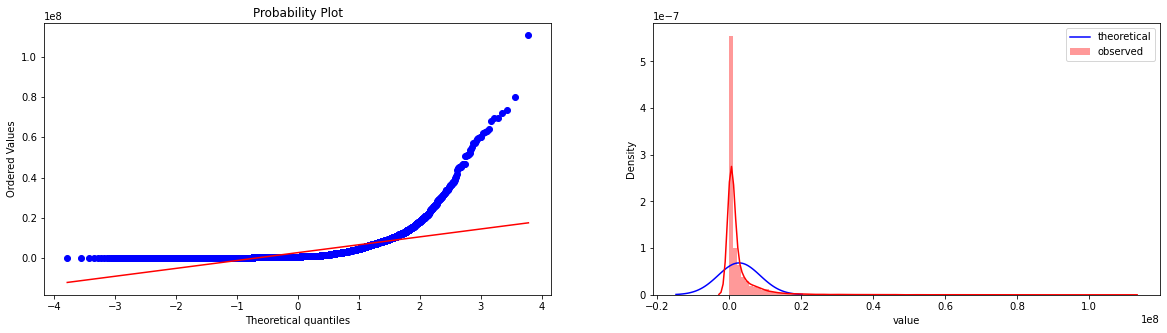

In [12]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

stats.probplot(train['value'],dist=stats.norm, plot=ax1)

mu = train['value'].mean()
var = train['value'].var()
sigma = var ** 0.5
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax2.plot(x, stats.norm.pdf(x,mu,sigma), color = 'blue', label='theoretical')

sns.distplot(ax=ax2, a=train['value'], bins=100, color = 'red', label='observed')
ax2.legend()

plt.show()

* 정규성 검정

#### log함수 적용

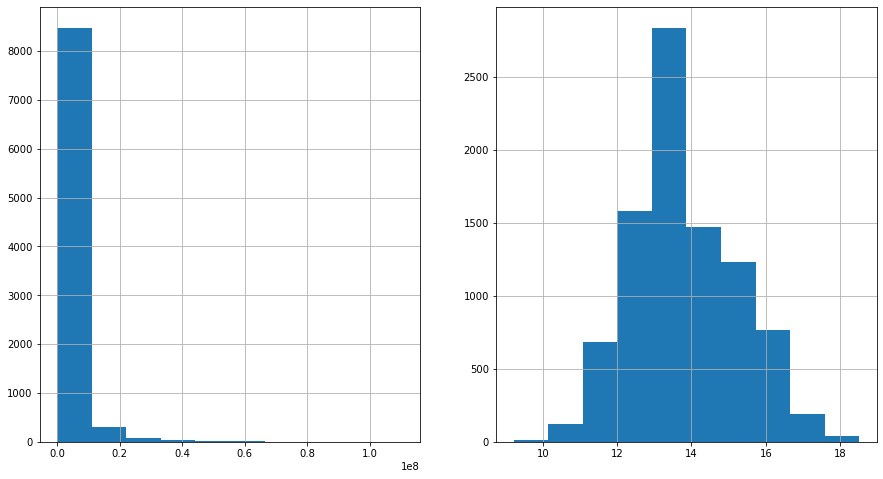

In [13]:
fig, ax = plt.subplots(1,2, figsize=(15,8))
ax = ax.flatten()

train_copy['value'].hist(ax=ax[0])
np.log1p(train_copy['value']).hist(ax=ax[1])
plt.show()

In [14]:
train_copy['value'] = np.log1p(train_copy['value'])

* log함수 적용 후 정규성 검정

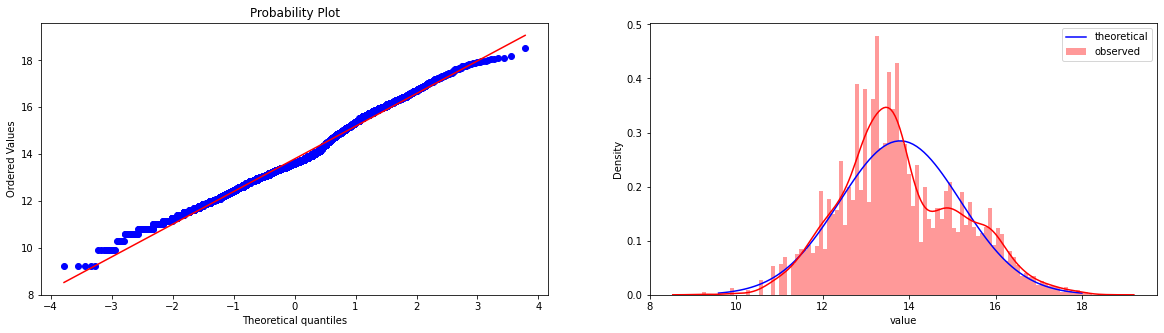

In [15]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

stats.probplot(train_copy['value'],dist=stats.norm, plot=ax1)

mu = train_copy['value'].mean()
var = train_copy['value'].var()
sigma = var ** 0.5
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax2.plot(x, stats.norm.pdf(x,mu,sigma), color = 'blue', label='theoretical')

sns.distplot(ax=ax2, a=train_copy['value'], bins=100, color = 'red', label='observed')
ax2.legend()

plt.show()

---

# 모델링

In [16]:
target = train_copy['value']
train_copy = train_copy.iloc[:,:-1]

In [17]:
object_le = LabelEncoder()
train_copy[['continent','position','prefer_foot']] = train_copy[['continent','position','prefer_foot']].apply(object_le.fit_transform)

train_copy = pd.get_dummies(data= train_copy, columns=['continent'], prefix=['continent'])
train_copy = pd.get_dummies(data= train_copy, columns=['position'], prefix=['position'])
train_copy = pd.get_dummies(data= train_copy, columns=['prefer_foot'], prefix=['prefer_foot'])

test_copy[['continent','position','prefer_foot']] = test_copy[['continent','position','prefer_foot']].apply(object_le.fit_transform)
test_copy = pd.get_dummies(data= test_copy, columns=['continent'], prefix=['continent'])
test_copy = pd.get_dummies(data= test_copy, columns=['position'], prefix=['position'])
test_copy = pd.get_dummies(data= test_copy, columns=['prefer_foot'], prefix=['prefer_foot'])

In [18]:
scaler = RobustScaler()
train_copy[['age','stat_overall','stat_potential']] = scaler.fit_transform(train_copy[['age','stat_overall','stat_potential']])
test_copy[['age','stat_overall','stat_potential']] = scaler.transform(test_copy[['age','stat_overall','stat_potential']])

In [ ]:
xgb_model = xgb.XGBRegressor(random_state=42,use_label_encoder=False,eval_metric='logloss')
xgb_model.fit(train_copy,target)
target_pred = xgb_model.predict(train_copy)
y_pred = xgb_model.predict(test_copy)

pred_exp = np.expm1(y_pred)

# LinearRegression model의 학습 RMSE

# RMSE 저장
score = []
RMSE = mean_squared_error(np.expm1(target),target_pred)**0.5
score.append({'model':'XGBRegressor log',
              'RMSE' : RMSE})
RMSE

In [ ]:
kfold = KFold(n_splits=5, random_state=42, shuffle=True)

In [ ]:
# 하이퍼파라미터하면 오히려 성능 저하,,,
xgb_model = xgb.XGBRegressor(random_state=42,
                             max_depth=10,
                             min_child_weight=8,
                             use_label_encoder=False,eval_metric='logloss')
param_grid = [{}]
grid_cv = GridSearchCV(xgb_model,param_grid=[{}], cv = kfold, n_jobs=-1)
grid_cv.fit(train_copy,target)
target_pred = grid_cv.predict(train_copy)
y_pred = grid_cv.predict(test_copy)

pred_exp = np.expm1(y_pred)

# LinearRegression model의 학습 RMSE

# RMSE 저장
score = []
RMSE = mean_squared_error(np.expm1(target),target_pred)**0.5
score.append({'model':'XGBRegressor log',
              'RMSE' : RMSE})
RMSE

---
#### Stacking

In [19]:
# 메타 모델을 위한 학습 및 테스트 데이터 만들기
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    kf = KFold(n_splits=n_folds, shuffle=True,random_state=42)
    # 빈 배열 생성
    train_fold_pred = np.zeros((X_train_n.shape[0],1))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        print('폴드 세트 : ', folder_counter, ' 시작')
        X_tr = X_train_n.iloc[train_index]
        y_tr = y_train_n.iloc[train_index]
        X_te = X_train_n.iloc[valid_index] 
        
        # 폴드 내 모델 학습
        model.fit(X_tr, y_tr)
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1) # y_train 예측, 폴드 끝나면 concat해야함
        test_pred[:, folder_counter] = model.predict(X_test_n) # y_test 예측, 폴드 끝나면 평균 낼거임
        
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    
    return train_fold_pred, test_pred_mean # 하나의 모델에 대한 학습데이터, 테스트 데이터 생성

* 이상치(메시 제거)

In [ ]:
# 객체 생성

rf_reg = RandomForestRegressor(random_state=42)
dt_reg = DecisionTreeRegressor(random_state=42)
ada_reg = AdaBoostRegressor(random_state=42)
gbm_reg = GradientBoostingRegressor(random_state=42)
cat_reg = cb.CatBoostRegressor(random_state=42)
xgb_final = xgb.XGBRegressor(random_state=42)

# 개별 모델로부터 메타 모델에 필요한 데이터 셋 만들기

rf_train, rf_test = get_stacking_base_datasets(rf_reg, train_copy.iloc[1:], target.iloc[1:], test_copy, 5)
dt_train, dt_test = get_stacking_base_datasets(dt_reg, train_copy.iloc[1:], target.iloc[1:], test_copy, 5)
ada_train, ada_test = get_stacking_base_datasets(ada_reg, train_copy.iloc[1:], target.iloc[1:], test_copy, 5)
gbm_train, gbm_test = get_stacking_base_datasets(gbm_reg, train_copy.iloc[1:], target.iloc[1:], test_copy, 5)
cat_train, cat_test = get_stacking_base_datasets(cat_reg, train_copy.iloc[1:], target.iloc[1:], test_copy, 5)

# 개별 모델로부터 나온 y_train 예측값들 옆으로 붙이기
Stack_final_X_train = np.concatenate((rf_train,dt_train,ada_train,gbm_train,cat_train), axis=1)
# 개별 모델로부터 나온 y_test 예측값들 옆으로 붙이기
Stack_final_X_test = np.concatenate((rf_test,dt_test,ada_test,gbm_test,cat_test), axis=1)

xgb_final.fit(Stack_final_X_train, target.iloc[1:])
stack_final = xgb_final.predict(Stack_final_X_test) 

In [ ]:
np.expm1(stack_final)

* 이상치를 제거하지 않는다

In [ ]:
# 객체 생성

rf_reg = RandomForestRegressor(random_state=42)
dt_reg = DecisionTreeRegressor(random_state=42)
ada_reg = AdaBoostRegressor(random_state=42)
gbm_reg = GradientBoostingRegressor(random_state=42)
cat_reg = cb.CatBoostRegressor(random_state=42)
xgb_final = xgb.XGBRegressor(random_state=42)

# 개별 모델로부터 메타 모델에 필요한 데이터 셋 만들기

rf_train, rf_test = get_stacking_base_datasets(rf_reg, train_copy, target, test_copy, 5)
dt_train, dt_test = get_stacking_base_datasets(dt_reg, train_copy, target, test_copy, 5)
ada_train, ada_test = get_stacking_base_datasets(ada_reg, train_copy, target, test_copy, 5)
gbm_train, gbm_test = get_stacking_base_datasets(gbm_reg, train_copy, target, test_copy, 5)
cat_train, cat_test = get_stacking_base_datasets(cat_reg, train_copy, target, test_copy, 5)

# 개별 모델로부터 나온 y_train 예측값들 옆으로 붙이기
Stack_final_X_train = np.concatenate((rf_train,dt_train,ada_train,gbm_train,cat_train), axis=1)
# 개별 모델로부터 나온 y_test 예측값들 옆으로 붙이기
Stack_final_X_test = np.concatenate((rf_test,dt_test,ada_test,gbm_test,cat_test), axis=1)

xgb_final.fit(Stack_final_X_train, target)
stack_final = xgb_final.predict(Stack_final_X_test) 

In [ ]:
# 객체 생성

rf_reg = RandomForestRegressor(random_state=42)
dt_reg = DecisionTreeRegressor(random_state=42)
ada_reg = AdaBoostRegressor(random_state=42)
gbm_reg = GradientBoostingRegressor(random_state=42)
cat_reg = cb.CatBoostRegressor(random_state=42)
et_reg = ExtraTreesRegressor(random_state=42)
xgb_final = xgb.XGBRegressor(random_state=42)

# 개별 모델로부터 메타 모델에 필요한 데이터 셋 만들기

rf_train, rf_test = get_stacking_base_datasets(rf_reg, train_copy, target, test_copy, 5)
dt_train, dt_test = get_stacking_base_datasets(dt_reg, train_copy, target, test_copy, 5)
ada_train, ada_test = get_stacking_base_datasets(ada_reg, train_copy, target, test_copy, 5)
gbm_train, gbm_test = get_stacking_base_datasets(gbm_reg, train_copy, target, test_copy, 5)
cat_train, cat_test = get_stacking_base_datasets(cat_reg, train_copy, target, test_copy, 5)
et_train, et_test = get_stacking_base_datasets(et_reg, train_copy, target, test_copy, 5)

# 개별 모델로부터 나온 y_train 예측값들 옆으로 붙이기
Stack_final_X_train = np.concatenate((rf_train,dt_train,ada_train,gbm_train,cat_train,et_train), axis=1)
# 개별 모델로부터 나온 y_test 예측값들 옆으로 붙이기
Stack_final_X_test = np.concatenate((rf_test,dt_test,ada_test,gbm_test,cat_test,et_test), axis=1)

xgb_final.fit(Stack_final_X_train, target)
stack_final = xgb_final.predict(Stack_final_X_test) 

In [5]:
np.expm1(stack_final)

In [ ]:
submission['value'] = np.expm1(stack_final)
# submission.to_csv('stacking extra tree.csv',index=False)

---  
하이퍼 파라미터

In [ ]:
rf_reg = RandomForestRegressor(random_state=42)
param_grid = {'n_estimators':[10,100],
              'max_depth':[4,6,8,10,12],
             'min_samples_leaf':[1,2,4,6,8,12,18],
             'min_samples_split':[2,4,6,8,16,20,24,26]}
grid_rf = GridSearchCV(rf_reg,param_grid = param_grid,cv=5,n_jobs=-1)
grid_rf.fit(train_copy,target)

rf = RandomForestRegressor(random_state=42,**grid_rf.best_params_)
# rf.fit(train_copy,target)

In [ ]:
dt_reg = DecisionTreeRegressor(random_state=42)
param_grid = {'max_depth':[4,6,8,10,12],
             'min_samples_leaf':[6,8,12,18],
             'min_samples_split':[4,6,8,16,20]}
grid_dt = GridSearchCV(dt_reg,param_grid = param_grid,cv=5,n_jobs=-1)
grid_dt.fit(train_copy,target)

dt = DecisionTreeRegressor(random_state=42,**grid_dt.best_params_)
# dt.fit(train_copy,target)

In [ ]:
ada_reg = AdaBoostRegressor(random_state=42)
param_grid = {'n_estimators':[100,150],
              'learning_rate':[0.01,0.1,0.5,1.0]}
grid_ada = GridSearchCV(ada_reg,param_grid = param_grid,cv=5,n_jobs=-1)
grid_ada.fit(train_copy,target)

ada = AdaBoostRegressor(random_state=42,**grid_ada.best_params_)

In [ ]:
gbm_reg = GradientBoostingRegressor(random_state=42)
param_grid = {'n_estimators':[100,150],
              'learning_rate':[0.01,0.1],
             'max_depth':[4,6,8,10,12],
             'min_samples_leaf':[6,8,12,18],
             'min_samples_split':[4,6,8,16,20]}
grid_gbm = GridSearchCV(gbm_reg,param_grid = param_grid,cv=5,n_jobs=-1)
grid_gbm.fit(train_copy,target)

gbm = GradientBoostingRegressor(random_state=42,**grid_gbm.best_params_)

In [ ]:
cat_reg = cb.CatBoostRegressor(random_state=42)
param_grid = {'depth':[2,3,4,5,6,7,8,9,10],
              'learning_rate':[0.01,0.05,0.1,0.2]}
grid_cat = GridSearchCV(cat_reg,param_grid = param_grid,cv=5,n_jobs=-1)
grid_cat.fit(train_copy,target)

cat = cb.CatBoostRegressor(random_state=42,**grid_cat.best_params_)

In [ ]:
# 객체 생성

grid_xgb = GridSearchCV(estimator = xgb.XGBRegressor(learning_rate = 0.1,
                             n_estimators=1000,
                             max_depth=3,
                             min_child_weight=5,
                             gamma=0,
                             reg_alpah=1e-05,
                             subsample=0.71,
                             colsample_bytree=0.6,
                             objective='reg:linear',
                             nthread=-1,
                             scale_pos_weight=1,
                             seed=42),
                       param_grid = [{}], scoring='neg_mean_squared_error')

# 개별 모델로부터 메타 모델에 필요한 데이터 셋 만들기

rf_train, rf_test = get_stacking_base_datasets(rf, train_copy, target, test_copy, 5)
dt_train, dt_test = get_stacking_base_datasets(dt, train_copy, target, test_copy, 5)
ada_train, ada_test = get_stacking_base_datasets(ada, train_copy, target, test_copy, 5)
gbm_train, gbm_test = get_stacking_base_datasets(gbm, train_copy, target, test_copy, 5)
cat_train, cat_test = get_stacking_base_datasets(cat, train_copy, target, test_copy, 5)

# 개별 모델로부터 나온 y_train 예측값들 옆으로 붙이기
Stack_final_X_train = np.concatenate((rf_train,dt_train,ada_train,gbm_train,cat_train), axis=1)
# 개별 모델로부터 나온 y_test 예측값들 옆으로 붙이기
Stack_final_X_test = np.concatenate((rf_test,dt_test,ada_test,gbm_test,cat_test), axis=1)

grid_xgb.fit(Stack_final_X_train, target)
stack_final_hyper = grid_xgb.predict(Stack_final_X_test) 

In [ ]:
np.expm1(stack_final_hyper)

In [20]:
# 가장 좋은 점수를 받은 모델

rf_reg = RandomForestRegressor(random_state=42)
dt_reg = DecisionTreeRegressor(random_state=42)
ada_reg = AdaBoostRegressor(random_state=42)
gbm_reg = GradientBoostingRegressor(random_state=42)
cat_reg = cb.CatBoostRegressor(random_state=42)
et_reg = ExtraTreesRegressor(random_state=42)
xgb_final = xgb.XGBRegressor(random_state=42)

# 개별 모델로부터 메타 모델에 필요한 데이터 셋 만들기

rf_train, rf_test = get_stacking_base_datasets(rf_reg, train_copy, target, test_copy, 5)
dt_train, dt_test = get_stacking_base_datasets(dt_reg, train_copy, target, test_copy, 5)
ada_train, ada_test = get_stacking_base_datasets(ada_reg, train_copy, target, test_copy, 5)
gbm_train, gbm_test = get_stacking_base_datasets(gbm_reg, train_copy, target, test_copy, 5)
cat_train, cat_test = get_stacking_base_datasets(cat_reg, train_copy, target, test_copy, 5)
et_train, et_test = get_stacking_base_datasets(et_reg, train_copy, target, test_copy, 5)

# 개별 모델로부터 나온 y_train 예측값들 옆으로 붙이기
Stack_final_X_train = np.concatenate((rf_train,dt_train,ada_train,gbm_train,cat_train,et_train), axis=1)
# 개별 모델로부터 나온 y_test 예측값들 옆으로 붙이기
Stack_final_X_test = np.concatenate((rf_test,dt_test,ada_test,gbm_test,cat_test,et_test), axis=1)

xgb_final.fit(Stack_final_X_train, target)
stack_final = xgb_final.predict(Stack_final_X_test) 

폴드 세트 :  0  시작
폴드 세트 :  1  시작
폴드 세트 :  2  시작
폴드 세트 :  3  시작
폴드 세트 :  4  시작
폴드 세트 :  0  시작
폴드 세트 :  1  시작
폴드 세트 :  2  시작
폴드 세트 :  3  시작
폴드 세트 :  4  시작
폴드 세트 :  0  시작
폴드 세트 :  1  시작
폴드 세트 :  2  시작
폴드 세트 :  3  시작
폴드 세트 :  4  시작
폴드 세트 :  0  시작
폴드 세트 :  1  시작
폴드 세트 :  2  시작
폴드 세트 :  3  시작
폴드 세트 :  4  시작
폴드 세트 :  0  시작
Learning rate set to 0.055861
0:	learn: 1.3193255	total: 58ms	remaining: 58s
1:	learn: 1.2579506	total: 59.8ms	remaining: 29.8s
2:	learn: 1.1997297	total: 61.2ms	remaining: 20.3s
3:	learn: 1.1439346	total: 62.6ms	remaining: 15.6s
4:	learn: 1.0897574	total: 63.9ms	remaining: 12.7s
5:	learn: 1.0383233	total: 65.2ms	remaining: 10.8s
6:	learn: 0.9899183	total: 66.5ms	remaining: 9.44s
7:	learn: 0.9441183	total: 67.9ms	remaining: 8.42s
8:	learn: 0.9005714	total: 69.1ms	remaining: 7.61s
9:	learn: 0.8587541	total: 70.6ms	remaining: 6.98s
10:	learn: 0.8197246	total: 71.9ms	remaining: 6.46s
11:	learn: 0.7812223	total: 73.1ms	remaining: 6.02s
12:	learn: 0.7465894	total: 74.4ms	remaining:

In [22]:
submission['value'] = np.expm1(stack_final)
submission

,id,value
0,1,5.490754e+07
1,2,1.071717e+08
2,4,8.632618e+07
3,5,1.071717e+08
4,6,6.394193e+07
...,...,...
3823,16924,6.000542e+04
3824,16929,4.903538e+04
3825,16932,5.903377e+04
3826,16937,5.006772e+04
